`/interactive-runner`

In [ ]:
!pip install gdown
import gdown
#from cld_data_processing import download_data

In [4]:
#!rm -rf /kaggle/working/data
#!rm /kaggle/working/data.zip

In [5]:
import keras

import pandas as pd
import random
import shutil
import tensorflow as tf
import os
import zipfile

from collections import Counter

from pathlib import Path
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model


from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

from tensorflow.data import Dataset

from typing import NamedTuple, Tuple

import matplotlib.pyplot as plt
import seaborn as sns

2024-03-24 22:59:17.244476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 22:59:17.244540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 22:59:17.246029: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
class Params(NamedTuple):
    """
    Job Parameters Struct
    """
    image_size: int
    batch_size: int
    epochs: int
    early_stopping: bool
    early_stopping_patience: int
    adjust_learning_rate: bool

In [7]:
tf.random.set_seed(67890)

DEFAULT_PARAMS = Params(255, 196, 50, True, 5, False)
DEFAULT_PARAMS

Params(image_size=255, batch_size=196, epochs=50, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)

`/data/data_processing.py`

In [8]:
import gdown
import keras
import pandas as pd
import shutil
import tensorflow as tf
import os
import zipfile

# handle different dir structure kaggle vs colab
try:
    from AMLS_II_assignment23_24.model.util import Params
except ModuleNotFoundError:
    pass

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.data import Dataset
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from typing import Tuple


def data_preprocessing(path: Path,
                       params: Params,
                       force=False) -> Tuple[Dataset, Dataset, Dataset, dict]:
    """
    """
    file = download_data(path, force)
    
    data_path = path / "data"
    if force:
        shutil.rmtree(data_path)
        
    if not data_path.exists():
        data_path.mkdir(parents=True, exist_ok=True)
       
        with zipfile.ZipFile(file, "r") as z:
            z.extractall(data_path)
        
    df_images = pd.read_csv((data_path / "train.csv"))
    
#     imgs1 = random.sample(df_images[df_images.label==3].image_id.tolist(), k=2577)
#     imgs2 = df_images[df_images.label!=3].image_id.tolist()
    
#     df_images = df_images[df_images.image_id.isin((imgs1+imgs2))].copy()
    
    X_train, X_test, y_train, y_test
        = train_test_split(df_images.image_id, df_images.label, test_size=0.2, random_state=12)
    
    X_train, X_valid, y_train, y_valid
        = train_test_split(X_train, y_train, test_size=0.25, random_state=12)
    
    train_path = create_ds_tree(X_train, y_train, data_path, "train")
    valid_path = create_ds_tree(X_valid, y_valid, data_path, "valid")
    test_path = create_ds_tree(X_test, y_test, data_path, "test")
    
    ds_train = create_dataset(train_path, params.image_size, params.batch_size)
    ds_valid = create_dataset(valid_path, params.image_size, params.batch_size)
    ds_test = create_dataset(test_path, params.image_size, params.batch_size)

    return ds_train, ds_valid, ds_test, extract_class_weights(df_images)


def download_data(path: Path, force=False) -> Path:
    """
    """
    url = "https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT"
    output = path / "data.zip"
    if not Path(output).exists() or force:
        gdown.download(url, str(output), quiet=False)
    return output


def create_ds_tree(x, y, path: Path, name: str) -> Path:
    """
    Creates the directory structure for the given dataset.
    """
    ds_path = path / name
    if not ds_path.exists():
        ds_path.mkdir(parents=True, exist_ok=True)

        for lab in y.unique():
            (ds_path / str(lab)).mkdir(exist_ok=True)

        source_path = path / "train_images"
        
        for img, lab in zip(x, y):
            src = source_path / img
            dest = ds_path / str(lab) / img
            shutil.move(src, dest)
        
    return ds_path


def create_dataset(path: Path, img_size: int, batch_size: int = None) -> Dataset:
    """
    """
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[img_size, img_size],
        batch_size=batch_size,
        seed=12345,
    )


def extract_class_weights(df_data: pd.DataFrame) -> dict:
    classes = df_data.label.unique()
    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=classes,
                                         y=df_data.label)

    return dict(zip(classes, class_weights))


def augment_dataset(ds: Dataset, num_repeats: int) -> Dataset:
    """
    """
    def augment(image, label):
        seed = 12345
        image = tf.image.random_flip_left_right(image, seed)
        image = tf.image.random_flip_up_down(image, seed)
        image = tf.image.random_brightness(image, 0.2, seed)
        return image, label

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    return (
        ds
        .repeat(num_repeats)
        .map(augment)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )

In [9]:
# def data_cleanup() -> None:
#     # clean-up
#     try:
#         os.rmdir((data_path / "train_images"))
#         os.remove(file)
#     except Exception:
#          pass

`/model/utils.py`

In [3]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.data import Dataset
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from typing import NamedTuple, Tuple


class Params(NamedTuple):
    """
    Job Parameters Struct
    """
    image_size: int
    batch_size: int
    epochs: int
    early_stopping: bool
    early_stopping_patience: int
    adjust_learning_rate: bool


@dataclass
class ModelWrapper():
    """
    Util class to hold the "outer" model, and the inner base model
    so that training can be fine-tuned.
    """
    
    model: keras.Model
    base_model: keras.Model
        

def create_model(base_model_fn: str, name: str, params: Params) -> ModelWrapper:
    """
    Create Keras application model, e.g.
        tf.keras.applications.EfficientNetV2B0
        tf.keras.applications.ConvNeXtBase
    with a custom top.
    """
    # i = 0
    # name=f"{name}-{(i:=i+1)}"
    # name = [name+str(i) for i in range(17)]
    inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    # Base
    base_model = base_model_fn(weights='imagenet', include_top=False)
    base_model.trainable = False
    # set training=F here per https://keras.io/guides/transfer_learning/
    x = base_model(inputs, training=False)
    # Head
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    return ModelWrapper(model, base_model)


def run_task(task_id: str, model_wrapper: ModelWrapper,
             ds_train: Dataset, ds_valid: Dataset, ds_test: Dataset,
             params: Params, weights = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    model = model_wrapper.model
    # train
    df_train = train(task_id, model, ds_train, ds_valid, params)
    # test
    test_result = model.evaluate(ds_test)
    df_test = create_test_record(task_id, test_result)
    # save CM too
    save_confusion_matrix(ds_test, model, task_id)
    return df_train, df_test


def train(task_id: str, model: Model,
             ds_train_: Dataset, ds_valid_: Dataset,
             params: Params, weights = None) -> pd.DataFrame:
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
   
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["task_id"] = task_id
    df_hist["epoch"] = df_hist.index
   
    return df_hist


def create_test_record(task_id: str, result: list[float]):
    return pd.DataFrame({"task_id": [task_id], "test_loss" : [result[0]], "test_accuracy": [result[1]]})


def save_confusion_matrix(ds: Dataset, model: Model, task_id: str) -> None:
    path = f"artefacts/conf_mat_{task_id}.png"
    probabilities = model.predict(ds)
    predictions = np.argmax(probabilities, axis=1)

    one_hot_labels = np.concatenate([y for x, y in ds], axis=0)
    labels = [np.argmax(x) for x in one_hot_labels]
    
    result = confusion_matrix(labels, predictions, labels=[0,1,2,3,4], normalize='pred')
    disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
    disp.plot()
    disp.ax_.set_title(task_id)
    
    print(f"Saving confusion matrix to {path}")
    disp.figure_.savefig(f"artefacts/conf_mat_{task_id}.png", dpi=300)

In [5]:
df = create_test_record("test_task", [1.0, 2.0])

In [8]:
pd.concat([df, create_test_record("test_task", [1.0, 2.0])])

,task_id,test_loss,test_accuracy
0,test_task,1.0,2.0
0,test_task,1.0,2.0


In [12]:




# Large VGG-like model
def fatVGG(cifarInput, num_classes, name="vgg"):
    name = [name+str(i) for i in range(17)]
    
    # convolution and max pooling layers
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[0])(cifarInput)
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[1])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[2])(vgg)
    vgg = Dropout(0.25, name=name[3])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[4])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[5])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[6])(vgg)
    vgg = Dropout(0.25, name=name[7])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[8])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[9])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[10])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[11])(vgg)
    vgg = Dropout(0.25, name=name[12])(vgg)

    # classification layers
    vgg = Flatten(name=name[13])(vgg)
    vgg = Dense(512, activation='relu', name=name[14])(vgg)
    vgg = Dropout(0.5, name=name[15])(vgg)
    vgg = Dense(num_classes, activation='softmax', name=name[16])(vgg)
    return vgg


def model_convnext_tiny(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_convnext_base(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_convnext_tiny_1fc(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_effnet(params: Params) -> Model:
    
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_effnetv2(params: Params) -> Model:
    
    base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def effnet2(params: Params) -> Model:
    base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    base_model.trainable = False
    inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model
    
    
#keras.utils.plot_model(mod.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


def train(task_id: str, model: Model,
             ds_train_: Dataset, ds_valid_: Dataset,
             params: Params, weights = None) -> pd.DataFrame:
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
   
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["task_id"] = task_id
    df_hist["epoch"] = df_hist.index
   
    return df_hist


def run_experiment(exp_id: str, sub_exp_id: int, model_fn: str,
                      ds_train_: Dataset, ds_valid_: Dataset, params: Params, weights = None) -> Tuple[Model, pd.DataFrame]:
    
    model = model_fn(params)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
    
    
    
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["exp_id"] = exp_id
    df_hist["sub_exp_id"] = sub_exp_id
    df_hist["epoch"] = df_hist.index
   
    return model, df_hist

In [13]:
def add_results(df_all_results, df_new_results):
    if df_all_results.empty:
        return df_new_results
    else:
        return pd.concat([df_all_results, df_new_results])
    

def add_test_results(df_all_results: pd.DataFrame, exp_id: str, res: list[float]):
    df_res = pd.DataFrame({"exp_id": [exp_id], "test_loss" : [res[0]], "test_accuracy": [res[1]]})
    if df_all_results.empty:
        return df_res
    else:
        return pd.concat([df_all_results, df_res])


def recover_results() -> pd.DataFrame:
    file = "results.csv"
    if Path(file).exists():
        return pd.read_csv(file)
    return pd.DataFrame()


def recover_test_results() -> pd.DataFrame:
    file = "test_results.csv"
    if Path(file).exists():
        return pd.read_csv(file)
    return pd.DataFrame()

In [14]:
def plot_experiment_results(df_history: pd.DataFrame, exp_id: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id == exp_id) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_loss = df[["epoch", "loss", "val_loss"]].groupby(["epoch"]).mean()
    df_loss_gap = df[["epoch", "loss_gap"]].groupby(["epoch"]).mean()
    df_acc = df[["epoch", "accuracy", "val_accuracy"]].groupby(["epoch"]).mean()
    df_loss.plot()
    df_loss_gap.plot()
    df_acc.plot();
    
def plot_experiments_comp(df_history: pd.DataFrame, exp_id: list, y_dim: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", y_dim]].groupby(["epoch", "exp_id"]).mean()
    sns.lineplot(data=df_grp, x="epoch", y=y_dim, hue="exp_id")

In [15]:
def plot_experiments_comp2(df_history: pd.DataFrame, exp_id: list, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", "val_accuracy", "val_loss", "loss_gap"]].groupby(["epoch", "exp_id"]).mean()
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 8))
    sns.lineplot(data=df_grp, x="epoch", y="val_accuracy", hue="exp_id",  ax=ax1)
    sns.lineplot(data=df_grp, x="epoch", y="val_loss", hue="exp_id",  ax=ax2)
    sns.lineplot(data=df_grp, x="epoch", y="loss_gap", hue="exp_id",  ax=ax3)

`main.py`

In [ ]:
tf.random.set_seed(67890)

#DEFAULT_PARAMS = model_util.Params(255, 196, 50, True, 5, False)
DEFAULT_PARAMS = model_util.Params(50, 196, 1, True, 5, False)
print(DEFAULT_PARAMS)

ARTIFACTS_PATH = Path("artefacts").mkdir(parents=True, exist_ok=True)

# Process Data
print("==== Loading Data ====")
cwd = os.getcwd()
ds_train, ds_valid, ds_test, class_weights = data.data_preprocessing(Path(cwd), DEFAULT_PARAMS)
print(f"Class Weights: {class_weights}")

print("==== Task A: Baseline Model ====")
baseline_model = model_util.create_model(tf.keras.applications.ConvNeXtBase, "baseline_model", DEFAULT_PARAMS)
df_train, df_test = model_util.run_task("convnextbase", baseline_model, ds_train, ds_valid, ds_test, DEFAULT_PARAMS)
print(df_train)
print(df_test)

print("==== Task B: Baseline + Data Augmentation ====")
ds_train_aug = data.augment_dataset(ds_train, 2)
baseline_model2 = model_util.create_model(tf.keras.applications.ConvNeXtBase, "baseline_model_aug", DEFAULT_PARAMS)
df_train, df_test = model_util.run_task("convnextbase", baseline_model2, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS)
print(df_train)
print(df_test)

In [17]:
cwd = os.getcwd()
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), DEFAULT_PARAMS)
print(f"Class Weights: {class_weights}")

#df_results = recover_results()
#df_test_results = recover_test_results()

Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Class Weights: {0: 3.9368905243790246, 3: 0.3252317981456148, 1: 1.954956601187757, 2: 1.7935456831517183, 4: 1.6606131160263873}


In [15]:
# augmented datasets
#ds_train_aug = augment_dataset(ds_train, 1)
#ds_train_aug_lg = augment_dataset(ds_train, 2)
#ds_train_aug_xlg = augment_dataset(ds_train, 4)

In [16]:
df_results.head()

""


In [17]:
df_test_results.head()

""


`experiments/tasks`

In [24]:
DEFAULT_PARAMS = Params(255, 196, 2, True, 5, False)

In [25]:
ARTIFACTS_PATH = Path("artefacts").mkdir(parents=True, exist_ok=True)


In [26]:
def run_task(task_id: str, model_wrapper: ModelWrapper,
             ds_train_: Dataset, ds_valid_: Dataset, ds_test_: Dataset,
             params: Params, weights = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    model = model_wrapper.model
    # train
    df_train = train(task_id, model, ds_train, ds_valid, DEFAULT_PARAMS)
    # test
    test_result = model.evaluate(ds_test)
    df_test = create_test_record(task_id, test_result)
    # save CM too
    save_confusion_matrix(ds_test, model, task_id)
    return df_train, df_test

In [27]:
def create_test_record(task_id: str, result: list[float]):
    return pd.DataFrame({"task_id": [task_id], "test_loss" : [result[0]], "test_accuracy": [result[1]]})

Using EarlyStopping
Epoch 1/2


I0000 00:00:1711321282.183251     498 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711321282.236356     498 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321282.236806     498 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321282.237332     498 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/66 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5706 - loss: 1.2415

W0000 00:00:1711321380.232610     499 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321380.232985     499 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321380.233537     499 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5713 - loss: 1.2390

W0000 00:00:1711321390.771458     497 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321390.771793     497 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321390.772266     497 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321432.045138     499 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321432.045596     499 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321432.046045     499 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.5720 - loss: 1.2365 - val_accuracy: 0.6988 - val_loss: 0.7895
Epoch 2/2
66/66 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6807 - loss: 0.8515 - val_accuracy: 0.7463 - val_loss: 0.6947
Restoring model weights from the end of the best epoch: 2.
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7529 - loss: 0.6842
 1/22 ━━━━━━━━━━━━━━━━━━━━ 3:13 9s/step

W0000 00:00:1711321592.226407     497 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321592.226798     497 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321592.227242     497 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step


W0000 00:00:1711321623.516857     496 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321623.517186     496 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711321623.517606     496 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


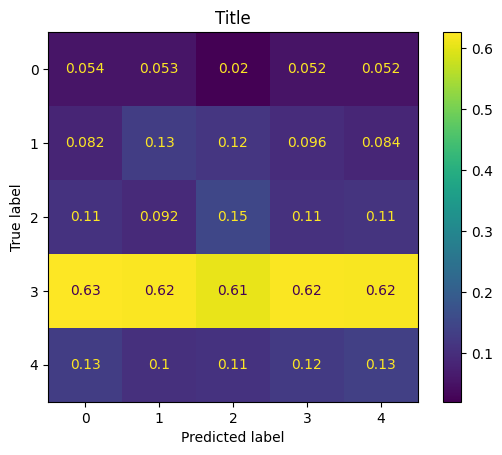

In [28]:
baseline_model = create_model(tf.keras.applications.ConvNeXtBase, "baseline_model", DEFAULT_PARAMS)
df_train, df_test = run_task("convnextbase", baseline_model, ds_train, ds_valid, ds_test, DEFAULT_PARAMS)

In [29]:
df_train

,index,accuracy,loss,val_accuracy,val_loss,task_id,epoch
0,0,0.617979,1.073591,0.698832,0.789482,convnextbase,0
1,1,0.688556,0.830277,0.746262,0.694713,convnextbase,1


In [31]:
df_test

,task_id,test_loss,test_accuracy
0,convnextbase,0.682921,0.758879


In [28]:
    df_train = run_task("model_convnext_tiny", baseline_model.model,
                   ds_train, ds_valid, DEFAULT_PARAMS)

Using EarlyStopping
Epoch 1/2


W0000 00:00:1711316805.446230      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316805.446760      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316805.447357      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/66 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5939 - loss: 1.1857

W0000 00:00:1711316897.558286      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316897.558753      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316897.559329      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5944 - loss: 1.1837

W0000 00:00:1711316907.260369      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316907.260831      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316907.261298      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316937.803347      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316937.803829      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711316937.804396      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.5949 - loss: 1.1818 - val_accuracy: 0.7063 - val_loss: 0.7846
Epoch 2/2
66/66 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6832 - loss: 0.8474 - val_accuracy: 0.7393 - val_loss: 0.6889
Restoring model weights from the end of the best epoch: 2.


In [51]:
df_results = add_results(df_results, df_hist)

In [52]:
df_results

,index,accuracy,loss,val_accuracy,val_loss,exp_id,epoch
0,0,0.625536,1.054757,0.706308,0.784627,model_convnext_tiny,0
1,1,0.690738,0.827267,0.739252,0.688928,model_convnext_tiny,1


In [30]:
baseline_model.model.evaluate(ds_valid)

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7351 - loss: 0.6851


[0.6893031597137451, 0.7392523288726807]

In [31]:
tr = baseline_model.model.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "convnext_tiny", tr)
tr

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7459 - loss: 0.6785


[0.6790671348571777, 0.7535046935081482]

In [ ]:
baseline_model.base_model.trainable = True
df_hist2 = run_task("convnext_tiny_ft", baseline_model.model,
                   ds_train, ds_valid, DEFAULT_PARAMS)

In [ ]:
tr2 = baseline_model.model.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "convnext_tiny_ft", tr2)
tr2

In [ ]:
df_test_results

22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step


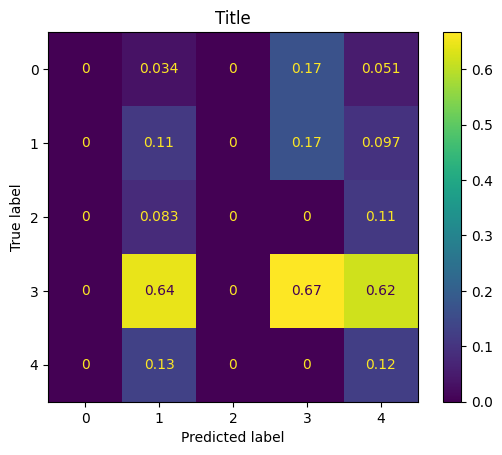

In [43]:
plot_confusion_matrix(ds_test, baseline_model.model)

In [ ]:
df_hist = run_task("model_convnext_tiny", baseline_model.model,
                   ds_train, ds_valid, DEFAULT_PARAMS)

In [ ]:
(m, df_hist) = run_experiment("model_convnext_tiny", 1, model_convnext_tiny, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m.evaluate(ds_test)

In [ ]:
(m1, df_hist) = run_experiment("model_convnext_base_orig_img", 1, model_convnext_base, augment_dataset(ds_train, 4), ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1.evaluate(ds_test)

In [ ]:
(m1a, df_hist) = run_experiment("model_convnext_base_orig_img_all", 1, model_convnext_base, augment_dataset(ds_train, 1), ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1.evaluate(ds_test)

In [ ]:
(m1b, df_hist) = run_experiment("model_convnext_base_orig_img_all_no_wgt", 1, model_convnext_base, augment_dataset(ds_train, 1), ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1b.evaluate(ds_test)

In [ ]:
(m2, df_hist) = run_experiment("model_convnext_tiny_aug_sm", 1, model_convnext_tiny, ds_train_aug, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m2.evaluate(ds_test)

In [ ]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug", "model_convnext_tiny_aug4_sm"], "val_accuracy")

In [ ]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug"], "val_loss")

In [ ]:
(m3, df_hist) = run_experiment("model_convnext_tiny_aug4_sm", 1, model_convnext_tiny, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m3.evaluate(ds_test)

In [ ]:
df_results.head()

In [ ]:
plot_experiments_comp(df_results,["model_convnext_tiny_aug", "model_convnext_tiny_sm", "model_convnext_tiny_aug_sm", "model_convnext_tiny_aug4_sm"], "val_accuracy")

In [ ]:
(m4, df_hist) = run_experiment("model_convnext_tiny_1fc", 1, model_convnext_tiny_1fc, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m4.evaluate(ds_test)

In [ ]:
plot_experiments_comp2(df_results,["model_convnext_tiny_1fc", "model_convnext_tiny_aug", "model_convnext_tiny_sm", "model_convnext_tiny_aug_sm", "model_convnext_tiny_aug4_sm"], "val_loss")

In [ ]:
(m4, df_hist) = run_experiment("model_effnetv2", 1, model_effnetv2, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m4.evaluate(ds_test)

In [ ]:
(m5, df_hist) = run_experiment("model_effnet", 1, model_effnet, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

r5 = m5.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "model_effnet", r5)
print(r5)

In [ ]:
(m6, df_hist) = run_experiment("model_effnet_wgts", 1, model_effnet, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

r6 = m6.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "model_effnet", r6)
print(r6)

In [ ]:
print(r6)

In [ ]:
(m7, df_hist) = run_experiment("effnet2", 1, effnet2, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

r7 = m7.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "effnet2", r6)
print(r7)

In [ ]:
plot_experiments_comp2(df_results,["model_effnet", "model_effnet_wgts"])

In [ ]:
plot_experiments_comp2(df_results,["model_convnext_tiny_1fc", "model_convnext_tiny_aug", "model_effnetv2", "model_effnet"])

In [ ]:
params = DEFAULT_PARAMS
weights = class_weights
    
base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
#x = keras.layers.Dense(1024, activation="relu")(x)
#x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=params.early_stopping_patience,
    restore_best_weights=True,
    verbose = 1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.3, 
    patience = 3, min_delta = 0.001, 
    mode = 'min', verbose = 1)

cbs = []
if params.early_stopping:
    print("Using EarlyStopping")
    cbs += [early_stopping]
if params.adjust_learning_rate:
    print("Using ReduceLROnPlateau")
    cbs += [reduce_lr]

history = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = None
)


In [ ]:
model.evaluate(ds_test)

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=1e-5),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history2 = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight=None
)

In [ ]:
model.evaluate(ds_test)
# [0.4968397915363312, 0.8268691301345825]

In [ ]:
model_eff = model

In [ ]:
params = DEFAULT_PARAMS
weights = class_weights
    
base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=params.early_stopping_patience,
    restore_best_weights=True,
    verbose = 1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.3, 
    patience = 3, min_delta = 0.001, 
    mode = 'min', verbose = 1)

cbs = []
if params.early_stopping:
    print("Using EarlyStopping")
    cbs += [early_stopping]
if params.adjust_learning_rate:
    print("Using ReduceLROnPlateau")
    cbs += [reduce_lr]

history = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = weights
)

In [ ]:
model.evaluate(ds_test)

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=1e-5),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history2 = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = weights
)

In [ ]:
model.evaluate(ds_test)

In [ ]:
preds = model.predict(ds_test)

In [ ]:
m1.evaluate(ds_test)

In [ ]:
m1.evaluate(ds_valid)

In [ ]:
probabilities = m1.predict(ds_test)
predictions = np.argmax(probabilities, axis=1)
Counter(predictions)

In [ ]:
xs = np.concatenate([x for x, y in ds_test], axis=0)

In [ ]:
probabilities = m1.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
Counter(predictions)

In [ ]:
probabilities = m1a.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
Counter(predictions)

In [ ]:
y = np.concatenate([y for x, y in ds_test2], axis=0)
ys = [np.argmax(x) for x in y]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(ys, predictions, labels=[0,1,2,3,4], normalize='pred')
print(result)

In [ ]:
disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

In [ ]:
ds_test2 = image_dataset_from_directory(
        Path("/kaggle/working/data/test/"),
        labels='inferred',
        label_mode='categorical',
        image_size=[255, 255],
        batch_size=196,
        shuffle=False
    )

In [ ]:
m1a.evaluate(ds_test2)

In [ ]:
probabilities = m1a.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
#Counter(predictions)

y = np.concatenate([y for x, y in ds_test2], axis=0)
ys = [np.argmax(x) for x in y]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(ys, predictions, labels=[0,1,2,3,4], normalize='pred')
disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

In [ ]:


def plot_confusion_matrix(ds: Dataset, model: Model) -> None:
    probabilities = model.predict(ds)
    predictions = np.argmax(probabilities, axis=1)

    one_hot_labels = np.concatenate([y for x, y in ds], axis=0)
    labels = [np.argmax(x) for x in one_hot_labels]
    
    result = confusion_matrix(labels, predictions, labels=[0,1,2,3,4], normalize='pred')
    disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
    disp.plot()
    plt.show()

In [ ]:
m1b.evaluate(ds_valid)

In [ ]:
m1b.evaluate(ds_test)

In [ ]:
plot_confusion_matrix(ds_test2, m1b)